# Determinación distancia entre dos bases de datos

## 0. Se cargan las bibliotecas

In [43]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 1. Lectura de Datos y  Definiciones de los Parámetros Relevantes

In [67]:
# Datos de AMB
data_AMB = pd.read_excel("datos_procesados_local_amb.xlsx")

# Datos de los sensores low cost
data_LOW_COST = pd.read_excel("datos_procesados_local_low_cost.xlsx")

In [20]:
data_AMB

,Time,AMB
0,2019-04-11 17:00:00,18.5
1,2019-04-11 18:00:00,18.9
2,2019-04-11 19:00:00,18.0
3,2019-04-11 20:00:00,18.4
4,2019-04-11 21:00:00,19.3
...,...,...
3409,2019-08-31 19:00:00,20.4
3410,2019-08-31 20:00:00,18.7
3411,2019-08-31 21:00:00,22.8
3412,2019-08-31 22:00:00,25.2


In [21]:
data_LOW_COST

,Time,Low-cost
0,2019-04-11 17:29:20.949,23.500000
1,2019-04-11 18:02:49.625,22.083334
2,2019-04-11 19:02:50.638,25.250000
3,2019-04-11 20:03:00.961,28.749998
4,2019-04-11 21:02:49.634,29.000000
...,...,...
3342,2019-09-01 00:02:50.912,6.166667
3343,2019-09-01 01:02:49.911,7.833333
3344,2019-09-01 02:02:49.912,5.416667
3345,2019-09-01 03:02:49.912,5.750000


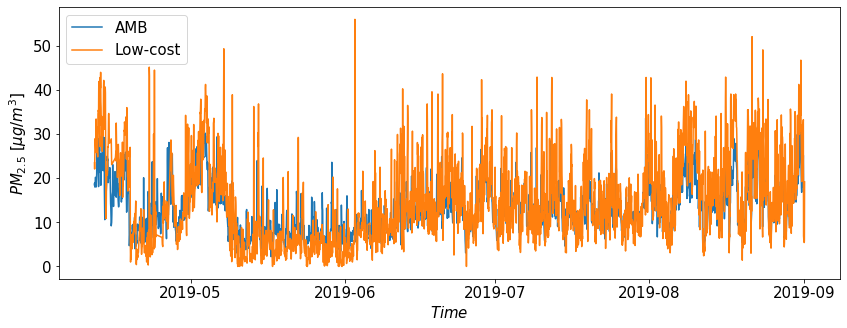

In [94]:
# Se convierten las fechas a formato datetime

data_AMB['Time']      = pd.to_datetime(data_AMB['Time'])
data_LOW_COST['Time'] = pd.to_datetime(data_LOW_COST['Time'])

# Se eliminan las filas con ceros en los archivos
data_AMB      = data_AMB.dropna()
data_LOW_COST = data_LOW_COST.dropna()

# Parametros del código

## Longitudes de las bases de datos
M = len(data_AMB)
N = len(data_LOW_COST)

## Intervalos inferior y superior del tiempo de AMB y low-cost
a1 = data_AMB['Time'][0]
b1 = data_AMB['Time'][M-1]

a2 = data_LOW_COST['Time'][0]
b2 = data_LOW_COST['Time'][N-1]

# Se grafican los datos originales
def plot_original_data():
    # Output: devuelve un grafico con los datos de AMB y los del sensor 
    #Low-cost
    
    plt.figure(figsize=(14,5))
    plt.plot(data_AMB['Time'],data_AMB['AMB'], label='AMB')
    plt.plot(data_LOW_COST['Time'],data_LOW_COST['Low-cost'], label='Low-cost')
    plt.xlabel(r'$Time$',fontsize=15)
    plt.ylabel(r'$PM_{2.5} \ [\mu g/m^3]$',fontsize=15)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
plot_original_data()

## 2. Función del promedio móvil

In [23]:
# Promedio con ventanas móviles
def fun(Eps=2, l=4, data_A=data_AMB.copy(), data_B=data_LOW_COST.copy(), a2=a2, b2=b2):
    # Output: la distancia euclediana y una lista con los promedios hallados
    
    # Longitud ventana
    l = datetime.timedelta(hours=l)

    # Largo del paso
    Eps = datetime.timedelta(hours=Eps)
    
    # Valor maximo de ciclos antes de que la ventana sobrepase el dominio de los datos
    Dominio = int((b2-a2-l)/Eps)
            
    Errores = []    # Lista que contendrá los errores entre promedios de 
                    # low-cost y AMB
    Promedios = []  # Lista que contendrá los datos promedios de low-cost y 
                    # AMB por ventana
    
    for i in range(Dominio):

        #window = [a2+Eps*i, a2+Eps*i+l]    # Inervalos de la ventana
        punto_medio = a2+Eps*i+l/2          # Punto medio de la ventana

        # Se hallan los indices de los datos que hacen parte de la ventana
        Indices1 = abs(data_A['Time']-punto_medio) <= l/2  
        Indices2 = abs(data_B['Time']-punto_medio) <= l/2  

        # Se guarda en una lista los datos contenidos en la ventana
        List1 = data_A[Indices1]
        List2 = data_B[Indices2]

        # Se promedian los datos de la ventana
        mean1 = List1['AMB'].values.mean()
        mean2 = List2['Low-cost'].values.mean()

        # Se estima el error entre los promedios
        error = abs(mean1-mean2)

        # Se guarda en la lista los errores y los promedios
        Errores.append(error)
        Promedios.append([mean1, mean2])

        # Se muestra en pantalla el progreso del ciclo for cada que 
        # se completa 1/4 del total
        if i % int(Dominio/4) < 1 and i>0:
            print('{}%'.format(int(i/Dominio*100)), end=' ')
    print('Finish!')

    # Se pasan los datos de errores y promedio a un DataFrame y se 
    # eliminan las filas con ceros
    Sets = pd.DataFrame({'Errores':Errores, 'Promedios':Promedios})
    Sets = Sets.dropna()
    
    # se guardan las nuevas listas
    Errores_new = list(Sets.loc[:,'Errores'])
    Promedios_new = list(Sets.loc[:,'Promedios'])
    
    # Se trasponen los datos de promedio
    Promedios_new = np.transpose(Promedios_new)
    
    # Se halla la cantidad de datos
    CANT_DATOS = len(Promedios_new[0])

    # Se halla la distancia entre los datos y su distancia relativa
    sumaq = np.sum(np.array(Errores_new)**2)
    DISTANCIA = np.sqrt(sumaq)
    DISTANCIA_REL = np.sqrt(sumaq/CANT_DATOS)
    
    return DISTANCIA, Promedios_new

# Se hace un test de la función
Eps1=2
l1=2
Promedio_1 = fun(Eps=Eps1, l=l1, data_A = data_AMB, data_B = data_LOW_COST)
print('D(Eps={}, l={}) = '.format(Eps1,l1),round(Promedio_1[0],ndigits=3))

25% 50% 75% Finish!
D(Eps=2, l=2) =  260.634


## 3. Graficando datos *Low-cost* vs datos *AMB*

25% 50% 75% Finish!


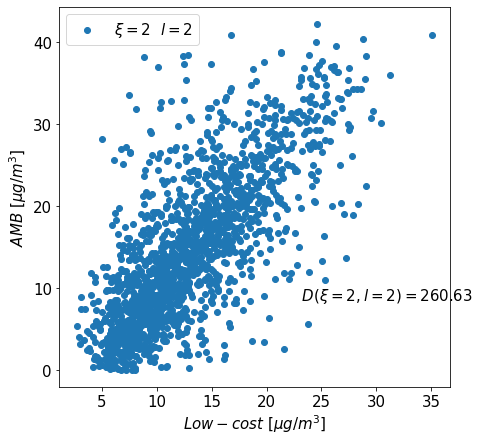

In [96]:
# Se halla la distancia entre los datos y se grafica un scatter 
# con los datos promedio

def plot_scatter(Eps=2, l=4, data_A=data_AMB.copy(), data_B=data_LOW_COST.copy()):
    
    # Output: distancia y promedio de los datos. Se muestra un gráfico 
    # con los promedios
    
    ## Distancia entre los datos
    DISTANCIA, Promedio = fun(Eps=Eps, l=l, data_A=data_A, data_B=data_B)
    
    ## Grafico de los promedios
    xdata = Promedio[0]
    ydata = Promedio[1]
    plt.scatter(xdata,ydata, label=r'$\xi = %1.0f \ \ l = %1.0f $'%(Eps, l))
    plt.xlabel(r'$Low-cost \ [\mu g/m^3]$',fontsize=15)
    plt.ylabel(r'$AMB \ [\mu g/m^3]$',fontsize=15)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    ## Se imprime en el grafico el valor de la distancia
    plt.text(max(xdata) * 6.5/10, (max(ydata)-min(ydata))*1/5+min(ydata),
             r' $ D(\xi = {}, l = {}) = {}$'.format(Eps,
             l, round(DISTANCIA,ndigits=2)), fontsize=15)
    
    return DISTANCIA, Promedio

# Se ignoran las advertencias del código
import warnings
warnings.filterwarnings('ignore')

# Prueba inicial de datos
Eps1=2
l1=2
plt.figure(figsize=(7,7))
D, P = plot_scatter(Eps1,l1)

## 4. Calibración de los datos

### 4.1 Determinación línea recta del ajuste lineal

25% 50% 75% Finish!
* Coeficients of Fit: m = 0.45, b = 6.35
* Sigma coeficients: δm = 0.01, δb = 0.17
* Error on fit RMSE = 3.669


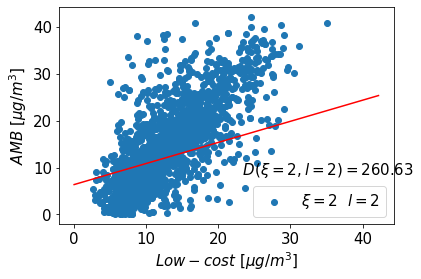

In [97]:
# Se define un ajuste lineal
def func_straight(x, m, b):
    y = m*x + b 
    return y

# Se encuentran los parámetros del ajuste
def params_straight(xdata,ydata):
    # xdata y ydata: datos variables independiente y dependiente, respectivamente.
    
    # Output: parámetros del ajuste y su covarianza. 
    # Se muestran los coeficientes, sus desviaciones estándar, y el error RMSE
    
    # Se usa curve_fit para encontrar los parámetros.
    params, cov = curve_fit(func_straight, xdata, ydata)
    
    # Se extrae la raiz cuadrada de la diagonal, es decir, la desviación estándar
    cov = np.sqrt(np.diag(cov))
    
    # Se muestra en pantalla los coeficientes de la función y sus correspondientes valores sigma.
    print("* Coeficients of Fit: m = %.2f, b = %.2f"%(params[0],params[1]))
    print("* Sigma coeficients: δm = %.2f, δb = %.2f"%(cov[0],cov[1]))
    
    # Se calcula el error de raíz de mínimos cuadrados (RMSE, por sus siglas en inglés).
    data_fit = func_straight(xdata, *params)          # Datos de ydata (LOW_COST) del ajuste 
    rmse = np.sqrt( np.mean( (ydata - data_fit)**2 ))
    print("* Error on fit RMSE = %.3f"%(rmse))
    
    return params, cov

def plot_linear_fit(Eps=1,l=1, data_A=data_AMB.copy(), data_B=data_LOW_COST.copy()):
    # Output: Parámetros de ajuste. Se Grafican datos promedio. Se usa plot_scatter() y params_straight()

    ## Datos del promedio móvil y grafica
    DISTANCIA, Promedios = plot_scatter(Eps=Eps, l=l, data_A=data_A, data_B=data_B)

    ## Ajuste de los datos
    PM_AMB = Promedios[1]
    PM_LOW_COST = Promedios[0]
    params, cov = params_straight(PM_AMB, PM_LOW_COST)

    ## Grafica de la línea recta
    x1, x2 = min(PM_AMB), max(PM_AMB)
    y1, y2 = func_straight(x1, *params), func_straight(x2, *params)
    plt.plot([x1,x2],[y1,y2],'-r')
    return params

# Prueba del ajuste lineal
Eps1=2
l1=2
params1 = plot_linear_fit(Eps1,l1)

### 4.2 Mostrando datos calibrados y datos deAMB

24% 49% 74% 99% Finish!


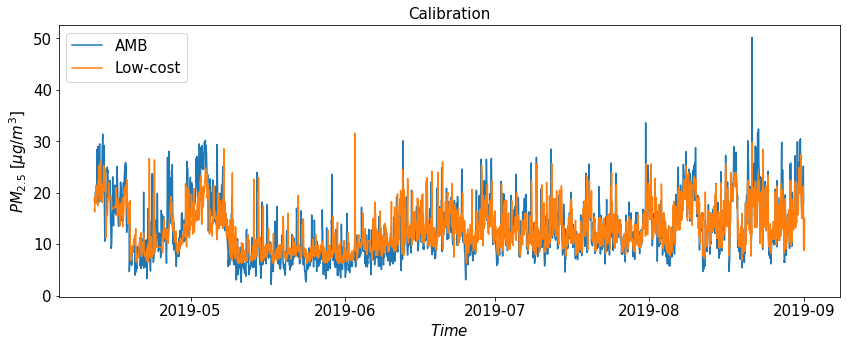

In [99]:
def plot_results(Eps, l, params):
    #Output: Se grafican los datos de AMB y los de Low-cost calibrados, y además, se halla 
    #        la distancia euclidea entre ellos
    
    ## Se grafican los datos calibrados
    plt.figure(figsize=(14,5))
    plt.plot(data_AMB['Time'],data_AMB['AMB'], label='AMB')
    data_Calibracion = pd.DataFrame({'Time':data_LOW_COST['Time'], 'Low-cost':params[0]*data_LOW_COST['Low-cost']+params[1]})
    plt.plot(data_Calibracion['Time'], data_Calibracion['Low-cost'], label='Low-cost')
    plt.xlabel(r'$Time$',fontsize=15)
    plt.ylabel(r'$PM_{2.5} \ [\mu g/m^3]$',fontsize=15)
    plt.title('Calibration',fontsize=15)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    ## Se halla la distancia euclidea entre los datos calibrados con los de referencia (AMB)
    DISTANCIA2, Promedio2 = fun(Eps=Eps, l=l, data_A=data_AMB.copy(), data_B=data_Calibracion.copy())
    
    # Posición del texto 
    loc = a1 + (b1-a1)/2
    
    # Se muestra texto en pantalla
    #plt.text(loc, 45,r' $ D(\xi=%.1f, l=%.0f)=%.2f$'%(Eps, l, DISTANCIA2))
    
plot_results(Eps=1, l=1, params=params1)

### 4.3 Determinación de la mejor distancia entre los datos

Los mejores valores de $\xi$ y $l$ para los cuales la distancia es mejor serán aquellos para los cuales el ajuste de los datos sea el mejor. Con el fin de comparar a la mejor distancia, se decidió definir una distancia relativa para comparar la distancia total entre la cantidad de datos:

$$ D_{rel} = \sqrt{ \frac{\sum_{i=0}^{N} (x_i - \hat{x_i})}{N} }$$

donde N es la cantidad de datos.

Igualmente, se decidió medir la distancia de cada calibración, realizando un promedio de ventanas móviles por horas. Es decir, con $\xi=1$ y $l=1$.

24% 49% 74% 99% Finish!
* Coeficients of Fit: m = 0.41, b = 6.94
* Sigma coeficients: δm = 0.01, δb = 0.09
* Error on fit RMSE = 4.075
24% 49% 74% 99% Finish!
D(Eps=1, l=1) =  235.01 
D_rel(Eps=1, l=1) =  4.07
24% 49% 74% 99% Finish!
* Coeficients of Fit: m = 0.41, b = 6.94
* Sigma coeficients: δm = 0.01, δb = 0.13
* Error on fit RMSE = 4.074
24% 49% 74% 99% Finish!
D(Eps=1, l=1) =  235.01 
D_rel(Eps=1, l=1) =  4.07
25% 50% 75% Finish!
* Coeficients of Fit: m = 0.45, b = 6.40
* Sigma coeficients: δm = 0.01, δb = 0.12
* Error on fit RMSE = 3.688
25% 50% 75% Finish!
D(Eps=1, l=1) =  235.86 
D_rel(Eps=1, l=1) =  4.09
25% 50% 75% Finish!
* Coeficients of Fit: m = 0.56, b = 4.77
* Sigma coeficients: δm = 0.00, δb = 0.08
* Error on fit RMSE = 2.051
25% 50% 75% Finish!
D(Eps=1, l=1) =  248.53 
D_rel(Eps=1, l=1) =  4.31
24% 49% 74% 99% Finish!
* Coeficients of Fit: m = 0.58, b = 4.39
* Sigma coeficients: δm = 0.01, δb = 0.14
* Error on fit RMSE = 1.432
24% 49% 74% 99% Finish!
D(Eps=1, l=1) =  

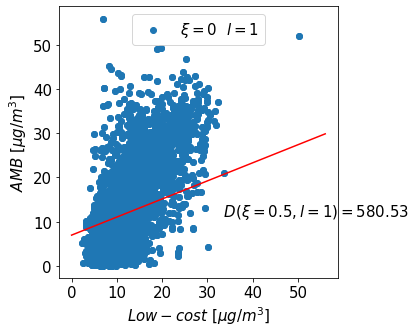

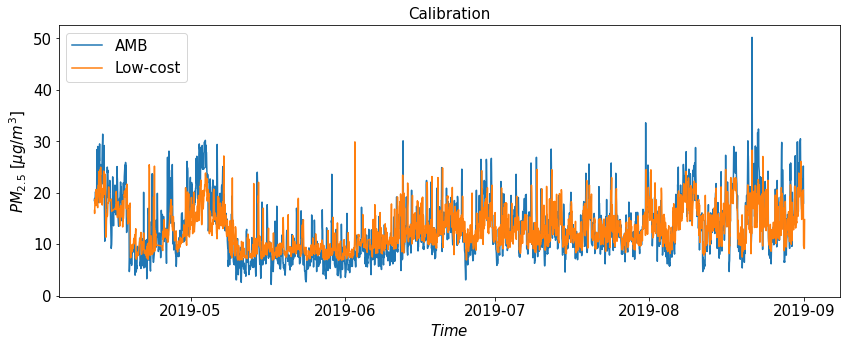

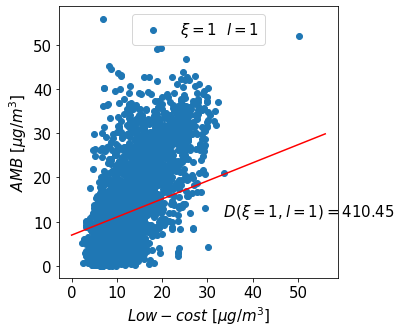

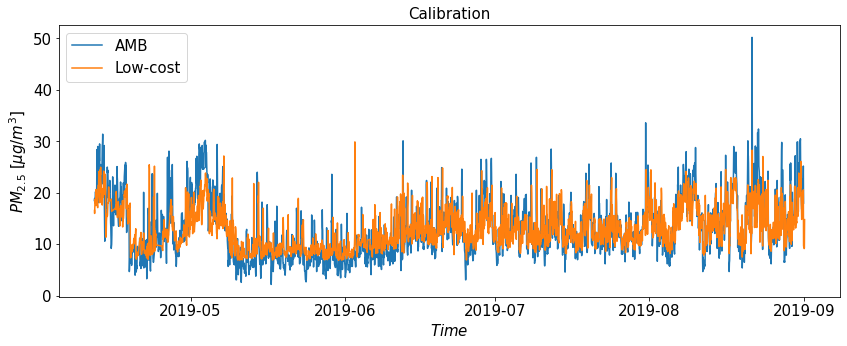

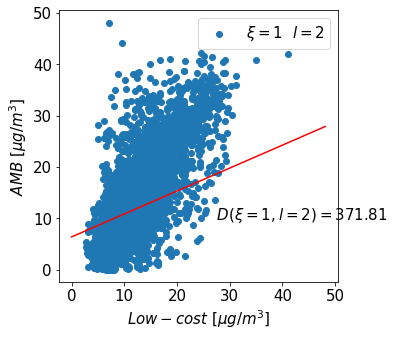

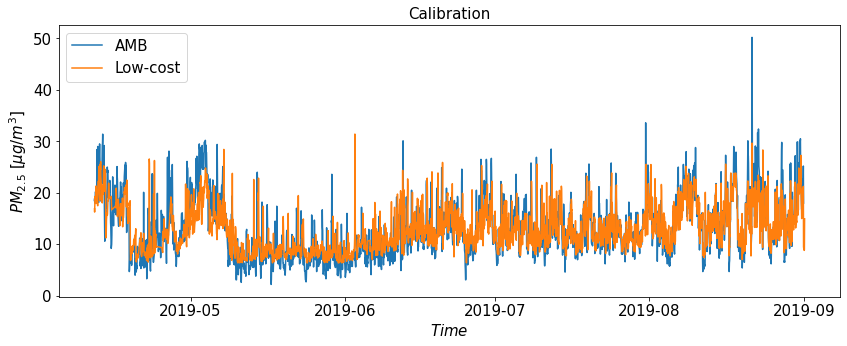

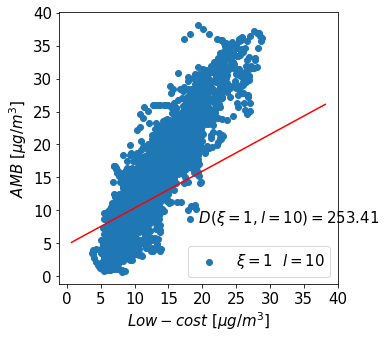

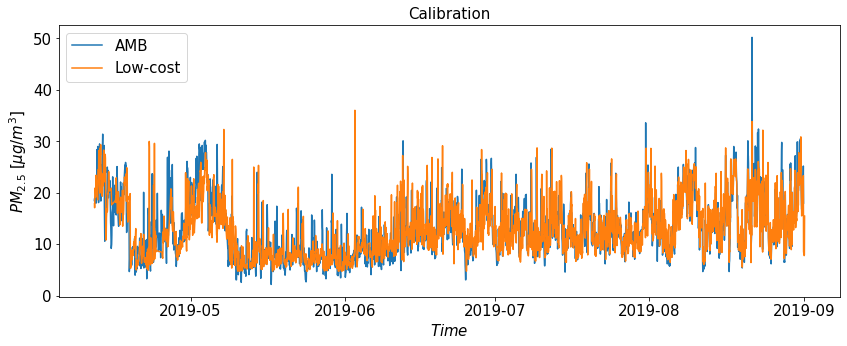

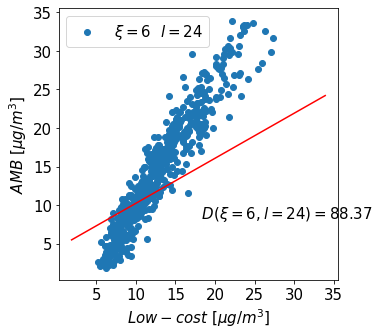

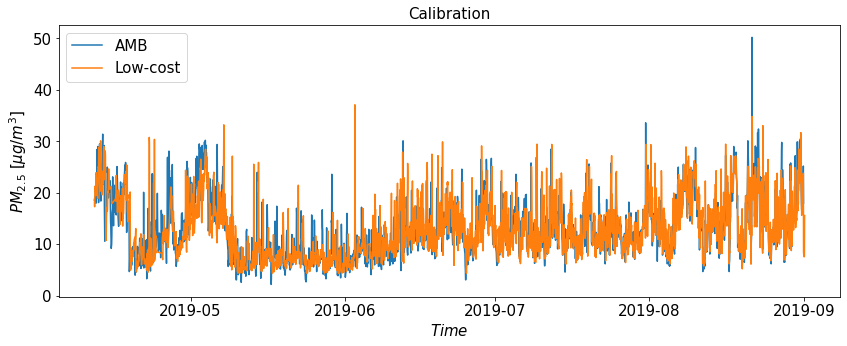

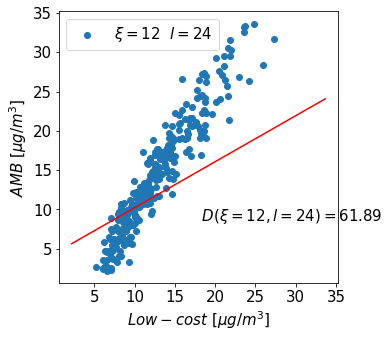

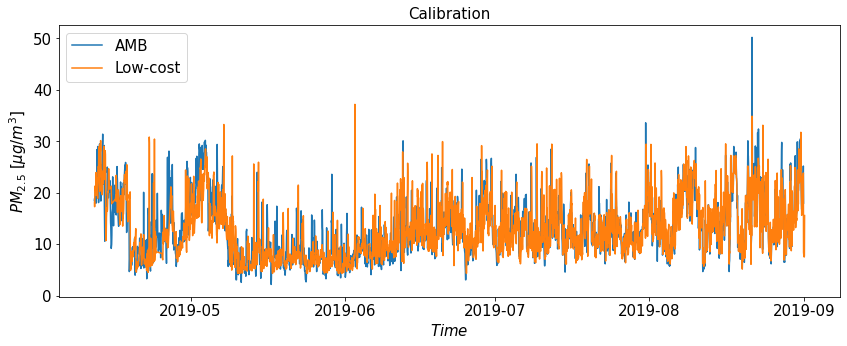

In [100]:
# Se realizan las grafias del ajuste, grafico de calibración vs AMB y
# también se hallan las distancias y las distancias relativas

def Calibration(Eps=1, l=2):
    # Output: Distancia, Distancia por unidad de dato. Se usan las funciones plot_linear_fit()
    #         plot_results() y Distancia_por_horas() para hacer la calibración
    
    ## Ajuste lineal
    plt.figure(figsize=(5,5))
    params = plot_linear_fit(Eps=Eps, l=l)
    
    ## Se grafican los resultados
    plot_results(Eps=Eps, l=l, params=params)
    
    ## Se halla la distancia entre AMB y los datos calibrados
    data_Calibration = data_LOW_COST.copy()
    data_Calibration['Low-cost'] = params[0]*data_LOW_COST['Low-cost']+params[1]
    Distancia, Distancia_relativa = Distancia_por_horas(data_AMB, data_Calibration)
    
    return [Distancia, Distancia_relativa, data_Calibration]

# Se crea la función para calcular la distancia por horas usando el método de resample de datos
def Distancia_por_horas(data_A, data_B, decimals=2):
    # Output: Distancia por horas, y Distancia por horas divida entre la cantidad de datos.
    
    ## Se ajusta la fecha de cada conjunto de datos y se pone a esta columna como índice.
    data_A['Time'] = pd.to_datetime(data_A['Time'])
    data_A = data_A.set_index('Time')

    data_B['Time'] = pd.to_datetime(data_B['Time'])
    data_B = data_B.set_index('Time')

    ## Se hace el resample de los datos, por horas
    data_A = data_A.resample('H').mean()
    data_B = data_B.resample('H').mean()

    data_A = data_A.dropna()
    data_B = data_B.dropna()
    
    data_A = pd.DataFrame({'Time':data_A.index.values, 'PM2.5':data_A['AMB'].values})
    data_B = pd.DataFrame({'Time':data_B.index.values, 'PM2.5':data_B['Low-cost'].values})
    alldata = pd.merge(data_A,data_B, on=["Time"])
    cant_datos = alldata.shape[0]
    Distancia = np.sqrt(np.sum( (alldata['PM2.5_x'].values-alldata['PM2.5_y'].values)**2 ))
    Distancia_rel = Distancia/np.sqrt(cant_datos)
    
    
    ## Se muestra en pantalla los resultados
    print('D(Eps=1, l=1) = ', '{}'.format(round(Distancia, ndigits=decimals)),
          '\nD_rel(Eps=1, l=1) = ', '{}'.format(round(Distancia_rel,ndigits=decimals)) )
    
    return Distancia, Distancia_rel

# Se realizan unas pruebas con varios valores de paso y longitud de la ventana
Eps = [0.5, 1, 1, 1, 6, 12]   # Lista con los datos de paso
l = [1, 1, 2, 10, 24, 24]     # Lista con los datos de longitud de ventana
D = [Calibration(Eps[i], l[i]) for i in range(len(Eps))] # Lista con la calibración de datos

In [101]:
# Se traspone la matriz con los datos de distancia de las calibraciones
Dt = np.transpose(D)

# Se crea el DataFrame con los valores de distancia
All_D = pd.DataFrame({'Eps':Eps, 'l':l, 'Distancia':Dt[0], 'Distancia relativa $[\mu g/m^3]$':Dt[1]})
All_D

,Eps,l,Distancia,Distancia relativa $[\mu g/m^3]$
0,0.5,1,235.009116,4.074962
1,1.0,1,235.009204,4.074964
2,1.0,2,235.863784,4.089782
3,1.0,10,248.526704,4.309352
4,6.0,24,253.468392,4.395039
5,12.0,24,253.94689,4.403336


### Conclusión

En base a lo anterior podemos decir que la mejor distancia es cuando la longitud de la ventana es pequeña. Adicionalmente, cuando el paso es pequeño también se consigue una mejora, como por ejemplo, al mantener constante $l=1$ y variar $\xi=0.5; 1$, obteniendo errores relativos de 0.4.074962 y 4.074964 respectivamente $[\mu g /m^3]$. Entonces, la mejor configuración de ventana es longitud de ventana $l=1$ y pasos de $\xi = 1$, pues cuando $\xi=0.5$ no se consiguen cambios perceptibles y además toma más tiempo de cómputo.

### 4.4 Comparación mejor ajuste y datos originales


-----------Datos originales------------

D(Eps=1, l=1) =  410.58 
D_rel(Eps=1, l=1) =  7.12

-----------Datos calibrados------------

24% 49% 74% 99% Finish!
* Coeficients of Fit: m = 0.41, b = 6.94
* Sigma coeficients: δm = 0.01, δb = 0.09
* Error on fit RMSE = 4.075
24% 49% 74% 99% Finish!
D(Eps=1, l=1) =  235.01 
D_rel(Eps=1, l=1) =  4.07


<Figure size 1008x432 with 0 Axes>

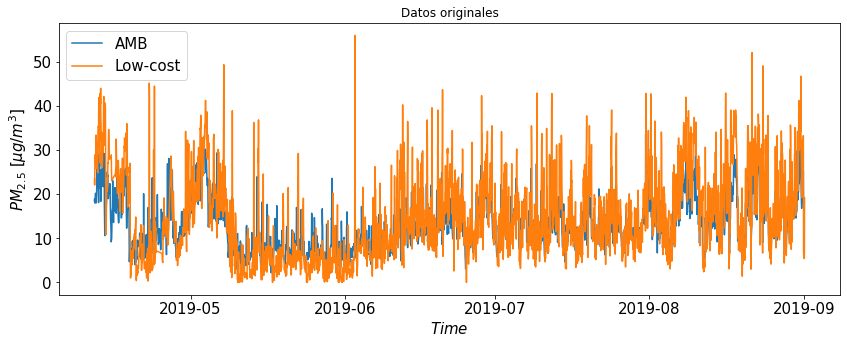

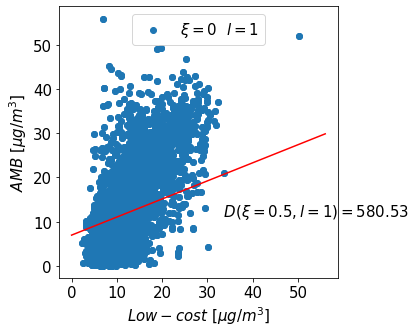

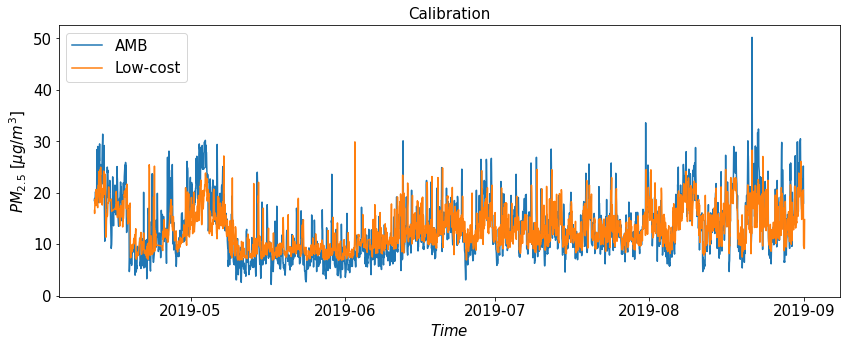

In [102]:
# Se muestran los datos originales y los datos calibrados
print('\n-----------Datos originales------------\n')
plt.figure(figsize = (14,6))
plot_original_data()
plt.title('Datos originales')
Distancia2 = Distancia_por_horas(data_AMB,data_LOW_COST)

print('\n-----------Datos calibrados------------\n')
D2 = Calibration(Eps=0.5, l=1)

### 4.5 Tolerancia Dispuesta a Aceptar

In [103]:
data_AMB.describe()

,AMB
count,3414.000000
mean,12.975952
std,5.608894
min,2.200000
25%,8.600000
50%,12.000000
75%,16.200000
max,50.200000


In [104]:
# Tolerancia a aceptar
mean = data_AMB.describe().loc['mean'].values[0]
Tolerancia = 10.0
print('Tolerancia = ', Tolerancia)

Tolerancia =  10.0


**Explicación**

El nivel de tolerancia corresponde al valor de concentración de PM 2.5 que estamos dispuestos a aceptar como error de los datos de Low-cost con los de AMB. En este caso, definiremos ese parámetro como 10.0 $\mu g/m^3$ que corresponde al orden de magnitudes del valor promedio de los datos de AMB. Para de esta forma, hacer que los datos tengan errores menores al orden de magnitudes de los datos de AMB, y así los datos calibrados se encuentren en el mismo orden de magnitudes de AMB.

Así, como se mencionó el valor de tolerancia es 10.0 $\mu g/ m^3$

## 5. Alcance del modelo lineal

24% 49% 74% 99% Finish!
* Coeficients of Fit: m = 0.41, b = 6.94
* Sigma coeficients: δm = 0.01, δb = 0.13
* Error on fit RMSE = 4.074
24% 49% 74% 99% Finish!
D(Eps=1, l=1) =  235.01 
D_rel(Eps=1, l=1) =  4.07
D(Eps=1, l=1) =  139.97 
D_rel(Eps=1, l=1) =  5.01
D(Eps=1, l=1) =  119.72 
D_rel(Eps=1, l=1) =  4.14
D(Eps=1, l=1) =  110.32 
D_rel(Eps=1, l=1) =  3.78
D(Eps=1, l=1) =  95.22 
D_rel(Eps=1, l=1) =  3.26


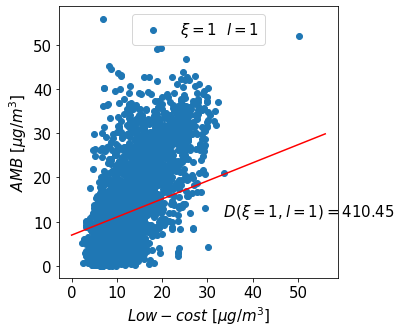

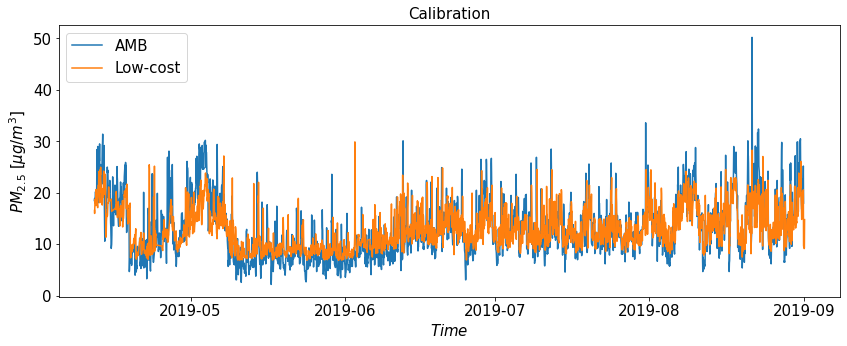

In [105]:
# Se hallan los datos de calibración
Eps, l = 1,1
list_Calibration = Calibration(Eps=Eps,l=l)

data_Calibration = list_Calibration[2]

# Se subdividen los datos de AMB y de Calibración en 4 partes
Ancho = (b1-a1)/4                                     #Ancho de cada sub-intervalo
Intervalos = [[a1,               a1 + 1*Ancho],
              [a1 + 1*Ancho, a1 + 2*Ancho],
              [a1 + 2*Ancho, a1 + 3*Ancho],
              [a1 + 3*Ancho, b1]]

# Se hallan los datos divididos

# Listas que contendrán los datos subdivididos
List_AMB = []
List_Calibration = []
for i in range(len(Intervalos)):
    
    # Sub-intervalo del ciclo
    sub_interval = Intervalos[i]
    
    # Punto medio del sub-intervalo
    punto_medio = sub_interval[0] + Ancho/2
    
    # Indices datos
    Indices1 = abs(data_AMB['Time'] - punto_medio) <= Ancho/2  
    Indices2 = abs(data_Calibration['Time'] - punto_medio) <= Ancho/2
    
    # Se guardan los datos en las listas
    List_AMB.append(data_AMB[Indices1])
    List_Calibration.append(data_Calibration[Indices2])

# Se determina la distancia entre AMB y Calibration sobre cada intervalo
Distancias_Intervalos = [Distancia_por_horas(List_AMB[i], List_Calibration[i]) for i in range(len(Intervalos))]

In [106]:
# Se trasponen las matrices de Distancias e Intervalos
Distancias_Intervalos_t = np.transpose(Distancias_Intervalos)
Intervalos_t = np.transpose(Intervalos)

# Se crea un DataFrame con las distancias
Distancias_Intervalos_df = pd.DataFrame({'Distancia':Distancias_Intervalos_t[0], 
                                         'Distancia relativa $[\mu g/m^3]$':Distancias_Intervalos_t[1],
                                         'Inicio':Intervalos_t[0],
                                         'Fin':Intervalos_t[1]})
Distancias_Intervalos_df

,Distancia,Distancia relativa $[\mu g/m^3]$,Inicio,Fin
0,139.967411,5.008428,2019-04-11 17:00:00,2019-05-17 06:30:00
1,119.715053,4.137958,2019-05-17 06:30:00,2019-06-21 20:00:00
2,110.324821,3.775238,2019-06-21 20:00:00,2019-07-27 09:30:00
3,95.223554,3.260392,2019-07-27 09:30:00,2019-08-31 23:00:00


**Conclusión**

Considerando el valor de tolerancia definido anteriormente de 10 $[\mu g/m^3]$, el alcance del modelo lineal corresponde a los datos contenidos en todo el conjunto de datos.

Observe que en los dos últimos sub-intervalos, la distancia relativa fue mejor en comparación con la distancia relativa de los datos completos.

## 6. Predicciones

### 6.1 Usando la mitad de los datos

24% 49% 74% 99% Finish!
* Coeficients of Fit: m = 1.10, b = -0.51
* Sigma coeficients: δm = 0.03, δb = 0.42
* Error on fit RMSE = 7.492
D(Eps=1, l=1) =  320.22167 
D_rel(Eps=1, l=1) =  7.74831
24% 49% 74% 99% Finish!


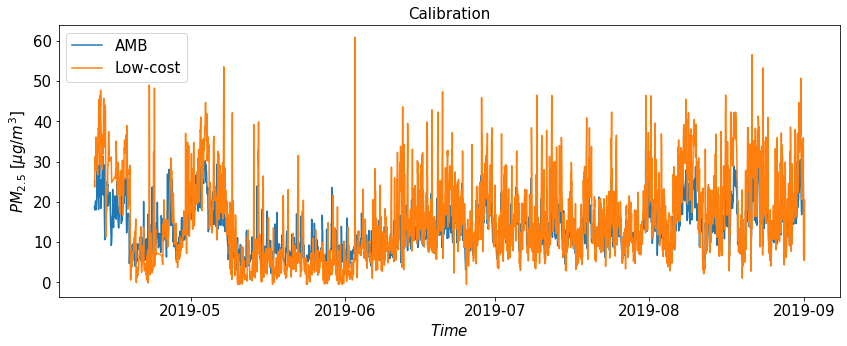

In [107]:
# Se crea una función para separar los datos
def separacion_datos(data_A=data_AMB.copy(), data_B=data_LOW_COST.copy(), a=a1, Ancho=(b1-a1)/2):
    #Output: datos separados de AMB, y de Low-cost que se calibrarán
    
    # Se hallan los indices de los datos antes y después de la división
    Indices1 = data_A['Time'] <= (a + Ancho)     #a1 es la fecha más atrás en el tiempo de los datos
    Indices2 = data_A['Time'] >= (a + Ancho)
    Indices3 = data_B['Time'] <= (a + Ancho)
    Indices4 = data_B['Time'] >= (a + Ancho)
    
    # Se hallan los datos divididos
    data_A1 = data_A[Indices1]
    data_A2 = data_A[Indices2]
    data_B1 = data_B[Indices3]
    data_B2 = data_B[Indices4]
    
    return data_A1, data_A2, data_B1, data_B2

def prediccion(data_A=data_AMB.copy(), data_B=data_LOW_COST.copy(), a=a1, Ancho=(b1-a1)/2,decimals=2):
    # Ancho: corresponde al intervalo que se usará para el ajuste de datos
    #        el ancho total de toda la data es (b1-a1)
    
    # Se separan los datos
    data_AMB_1, data_AMB_2, data_train, data_B2 = separacion_datos(data_A=data_A, data_B=data_B, a=a, Ancho=Ancho)
    
    # Se hallan los promedios con el método de promedio móvil
    Distancia, Promedio = fun(Eps=1, l=1, data_A=data_AMB_1.copy(), data_B=data_train.copy(),a2=a, b2=a+Ancho)
    
    # Se hace el ajuste de los datos promedios
    params, cov = params_straight(Promedio[0], Promedio[1])
    
    # Se calibran los datos con los parámetros de ajuste
    data_Calibration = data_B2.copy()
    data_Calibration['Low-cost'] = params[0]*data_Calibration['Low-cost']+params[1]
    
    # Se hallan las distancias entre los datos por fuera del dominio de entrenamiento
    Distancia, Distancia_relativa = Distancia_por_horas(data_AMB_2.copy(), data_Calibration.copy(),decimals=decimals)
    
    return Distancia, Distancia_relativa, params

Distancia, Distancia_relativa, params2 = prediccion(Ancho = (b1-a1)/2 ,decimals=5)
plot_results(Eps=1, l=1, params=params2)

**Conclusión**

Lo anterior muestra que tomando la mitad de los datos ($Ancho = (b1-a1)/2$) se obtiene una buena calibración para los datos que siguen a continuación. En este caso, la distancia relativa por horas fue $D_{rel}(Eps=1, l=1) =  7.75$, que es un valor por debajo del márgen de tolerancia.

Cabe destacar que el resultado de distancia relativa fue peor que al hacer el ajuste con todos los datos.

### 6.2 Alcance ajuste anterior

In [108]:
## Se realiza un código similar al hecho anteriormente para el alcance del primer modelo líneal

data_Calibration = data_LOW_COST.copy()

data_Calibration['Low-cost'] = params2[0]*data_LOW_COST['Low-cost']+params2[1]

# Se subdividen los datos de AMB y de Calibración en 6 partes
a = a1 + (b1-a1)/2         #Valor inferior del sub-intervalo donde se realiza la predicción              
Ancho = (b1-a)/6           #Ancho de cada sub-intervalo
Intervalos = [[a,           a + 1*Ancho],
              [a + 1*Ancho, a + 2*Ancho],
              [a + 2*Ancho, a + 3*Ancho],
              [a + 3*Ancho, a + 4*Ancho],
              [a + 4*Ancho, a + 5*Ancho],
              [a + 5*Ancho, b1]]

# Se hallan los datos divididos

# Listas que contendrán los datos subdivididos
List_AMB = []
List_Calibration = []
for i in range(len(Intervalos)):
    
    # Sub-intervalo del ciclo
    sub_interval = Intervalos[i]
    
    # Punto medio del sub-intervalo
    punto_medio = sub_interval[0] + Ancho/2
    
    # Indices datos
    Indices1 = abs(data_AMB['Time'] - punto_medio) <= Ancho/2  
    Indices2 = abs(data_Calibration['Time'] - punto_medio) <= Ancho/2
    
    # Se guardan los datos en las listas
    List_AMB.append(data_AMB[Indices1])
    List_Calibration.append(data_Calibration[Indices2])

# Se determina la distancia entre AMB y Calibration sobre cada intervalo
Distancias_Intervalos2 = [Distancia_por_horas(List_AMB[i], List_Calibration[i]) for i in range(len(Intervalos))]

# Se trasponen las matrices de Distancias e Intervalos
Distancias_Intervalos2_t = np.transpose(Distancias_Intervalos2)
Intervalos2_t = np.transpose(Intervalos)

# Se crea un DataFrame con las distancias
Distancias_Intervalos2_df = pd.DataFrame({'Distancia':Distancias_Intervalos2_t[0], 
                                         'Distancia relativa $[\mu g/m^3]$':Distancias_Intervalos2_t[1],
                                         'Inicio':Intervalos2_t[0],
                                         'Fin':Intervalos2_t[1]})
Distancias_Intervalos2_df

D(Eps=1, l=1) =  130.12 
D_rel(Eps=1, l=1) =  7.71
D(Eps=1, l=1) =  133.43 
D_rel(Eps=1, l=1) =  7.92
D(Eps=1, l=1) =  115.07 
D_rel(Eps=1, l=1) =  6.82
D(Eps=1, l=1) =  129.24 
D_rel(Eps=1, l=1) =  7.67
D(Eps=1, l=1) =  148.57 
D_rel(Eps=1, l=1) =  8.8
D(Eps=1, l=1) =  125.18 
D_rel(Eps=1, l=1) =  7.43


,Distancia,Distancia relativa $[\mu g/m^3]$,Inicio,Fin
0,130.117756,7.707511,2019-06-21 20:00:00,2019-07-03 16:30:00
1,133.431763,7.917718,2019-07-03 16:30:00,2019-07-15 13:00:00
2,115.067615,6.816017,2019-07-15 13:00:00,2019-07-27 09:30:00
3,129.244855,7.669271,2019-07-27 09:30:00,2019-08-08 06:00:00
4,148.566325,8.800310,2019-08-08 06:00:00,2019-08-20 02:30:00
5,125.184056,7.428307,2019-08-20 02:30:00,2019-08-31 23:00:00


Al realizar el analisis del alcance, el ajuste se mantiene dentro de la tolerancia para cada sub-intervalo. Adicionalmente, el mejor rango donde los datos se ajustaron mejor fue en el tercero, que va desde '2019-07-15 13:00:00' a	'2019-07-27 09:30:00'.

Por esto, el alcance de los datos corresponde a todo el conjunto de valores donde se hizo la predicción (segunda mitad de los datos originales, que no se usaron en el ajuste).

### 6.1 Variación del conjunto de datos para predecir

In [109]:
# Testeo de predicción para anchos de ventana diferentes. Se añade la variación en el punto inicial de tomar los datos.

# a1: fecha donde comienzan los datos de medición
# (b1-a1): delta de la longitud temporal total de los datos. Es el 'ancho' de los datos.

# Se definen listas de anchos e incios para la predicción
List_ANCHO = [(b1-a1)*0.5, (b1-a1)*0.4, (b1-a1)*0.3, (b1-a1)*0.15 ]
List_START = [a1, a1 + (b1-a1)*0.3,  a1 + (b1-a1)*0.5]

# Se crea una matriz para testear las variables una a una
M_ANCHO, M_START = np.meshgrid(np.array(List_ANCHO),np.array(List_START)) 

# Se encuentran las predicciones
List_PREDICT = []
for i in range(len(List_START)):
    List_PREDICT.append([list(prediccion(Ancho=M_ANCHO[i][j], a=M_START[i][j], decimals=4)) for j in range(len(List_ANCHO))])

24% 49% 74% 99% Finish!
* Coeficients of Fit: m = 1.10, b = -0.51
* Sigma coeficients: δm = 0.03, δb = 0.42
* Error on fit RMSE = 7.492
D(Eps=1, l=1) =  320.2217 
D_rel(Eps=1, l=1) =  7.7483
25% 50% 75% Finish!
* Coeficients of Fit: m = 1.16, b = -1.93
* Sigma coeficients: δm = 0.03, δb = 0.42
* Error on fit RMSE = 7.192
D(Eps=1, l=1) =  378.6351 
D_rel(Eps=1, l=1) =  8.3667
24% 49% 74% 99% Finish!
* Coeficients of Fit: m = 1.16, b = -1.23
* Sigma coeficients: δm = 0.04, δb = 0.53
* Error on fit RMSE = 7.477
D(Eps=1, l=1) =  408.1619 
D_rel(Eps=1, l=1) =  8.3771
24% 49% 74% 99% Finish!
* Coeficients of Fit: m = 1.12, b = 0.17
* Sigma coeficients: δm = 0.06, δb = 0.97
* Error on fit RMSE = 7.915
D(Eps=1, l=1) =  451.6706 
D_rel(Eps=1, l=1) =  8.4091
24% 49% 74% 99% Finish!
* Coeficients of Fit: m = 0.88, b = 2.64
* Sigma coeficients: δm = 0.04, δb = 0.50
* Error on fit RMSE = 6.876
D(Eps=1, l=1) =  160.3034 
D_rel(Eps=1, l=1) =  6.1338
25% 50% 75% Finish!
* Coeficients of Fit: m = 0.85,

In [110]:
pd.DataFrame({'Incio':np.transpose(List_PREDICT[0])[1],
              '0.3 veces el ancho total':np.transpose(List_PREDICT[1])[1], 
              '0.5 veces el ancho total':np.transpose(List_PREDICT[2])[1]}, 
              index=[
                  str(((b1-a1)*0.5).days)+ ' dias', 
                  str(((b1-a1)*0.4).days)+ ' dias', 
                  str(((b1-a1)*0.3).days)+ ' dias', 
                  str(((b1-a1)*0.15).days)+' dias']).rename_axis('Anchos / Inicios')

,Incio,0.3 veces el ancho total,0.5 veces el ancho total
Anchos / Inicios,,,
71 dias,7.748306,6.133838,10.046118
56 dias,8.366732,5.578777,9.064115
42 dias,8.37707,5.654031,6.056849
21 dias,8.409088,4.637825,5.117719


**Conclusión**

Como conclusión general se obtuvo que los mejores ajustes de la predicción fueron cuando el punto de inicio era mayor. Esto puede explicarse debido a que según la gráfica, los primeros datos no se parecen tanto a los que siguen, y por tanto la predicción mejora al ignorar estos datos. Adicionalmente el tamaño de la ventana generó resultados dispares, pues en algunos casos al aumentar el ancho la distancia relativa aumentaba, pero en otros, disminuía.

El mejor conjunto de datos obtenidos anteriormente fue el de Ancho de 56 días e inicio desde 0.5 veces el ancho de la ventana. Es decir, el conjunto de datos con ancho de 56 días tomados a partir de la mitad de los datos.

### 6.2 Alcance del mejor conjunto de datos

In [111]:
## Se realiza un código similar al hecho anteriormente para el alcance del primer modelo líneal
start = a1 + (b1-a1)*0.5                         # Fecha del inicio de los datos
params3 = np.transpose(List_PREDICT[2])[2][1]    # Parametros del mejor conjunto de datos
Mejor_ancho = (b1-a1)*0.4                             # Mejor ancho de los datos

data_C = data_AMB.copy()
data_D = data_LOW_COST.copy()

IndicesC = data_C['Time'] >= (start + Mejor_ancho)
IndicesD = data_D['Time'] >= (start + Mejor_ancho)

# Se hallan los datos divididos
data_C1 = data_C[IndicesC]
data_D1 = data_D[IndicesD]

data_Calibration1 = data_D1.copy()
data_Calibration1['Low-cost'] = params3[0]*data_LOW_COST['Low-cost']+params3[1]


# Se subdividen los datos de AMB y de Calibración en 6 partes
ancho3 = (b1-start-Mejor_ancho)/4                        # Ancho de cada sub-intervalo

Intervalos = [[start + Mejor_ancho,         start + Mejor_ancho + 1*ancho3],
              [start + Mejor_ancho + 1*ancho3, start + Mejor_ancho + 2*ancho3],
              [start + Mejor_ancho + 2*ancho3, start + Mejor_ancho + 3*ancho3],
              [start + Mejor_ancho + 3*ancho3, b1]]

# Se hallan los datos divididos

# Listas que contendrán los datos subdivididos
List_AMB = []
List_Calibration = []
for i in range(len(Intervalos)):
    
    # Sub-intervalo del ciclo
    sub_interval = Intervalos[i]
    
    # Punto medio del sub-intervalo
    punto_medio = sub_interval[0] + ancho3/2
    
    # Indices datos
    Indices1 = abs(data_AMB['Time'] - punto_medio) <= ancho3/2  
    Indices2 = abs(data_Calibration['Time'] - punto_medio) <= ancho3/2
    
    # Se guardan los datos en las listas
    List_AMB.append(data_AMB[Indices1])
    List_Calibration.append(data_Calibration[Indices2])

# Se determina la distancia entre AMB y Calibration sobre cada intervalo
Distancias_Intervalos3 = [Distancia_por_horas(List_AMB[i], List_Calibration[i]) for i in range(len(Intervalos))]

# Se trasponen las matrices de Distancias e Intervalos
Distancias_Intervalos3_t = np.transpose(Distancias_Intervalos3)
Intervalos3_t = np.transpose(Intervalos)

# Se crea un DataFrame con las distancias
Distancias_Intervalos3_df = pd.DataFrame({'Distancia':Distancias_Intervalos3_t[0], 
                                         'Distancia relativa $[\mu g/m^3]$':Distancias_Intervalos3_t[1],
                                         'Inicio':Intervalos3_t[0],
                                         'Fin':Intervalos3_t[1]})
Distancias_Intervalos3_df

D(Eps=1, l=1) =  72.63 
D_rel(Eps=1, l=1) =  7.88
D(Eps=1, l=1) =  75.86 
D_rel(Eps=1, l=1) =  8.18
D(Eps=1, l=1) =  47.98 
D_rel(Eps=1, l=1) =  5.2
D(Eps=1, l=1) =  78.17 
D_rel(Eps=1, l=1) =  8.48


,Distancia,Distancia relativa $[\mu g/m^3]$,Inicio,Fin
0,72.626383,7.877437,2019-08-17 17:36:00,2019-08-21 06:57:00
1,75.859962,8.180190,2019-08-21 06:57:00,2019-08-24 20:18:00
2,47.983343,5.204524,2019-08-24 20:18:00,2019-08-28 09:39:00
3,78.167690,8.478476,2019-08-28 09:39:00,2019-08-31 23:00:00


**Conclusión**

En los cuatro casos, los valores de distancia relativa estuvieron por debajo del rango de lo tolerancia. Por lo cual, todos ellos cumplen con ser un buen ajuste.